In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import re
from matplotlib import pyplot as plt
from matplotlib.ticker import LogLocator
from pprint import pprint
tool_dir0 = '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/ESMF_profiling'
sys.path.append(tool_dir0)
from esmf_related_functions import _read_ryaml, _expt_fullname, _extract_ntasks_values, _extract_restart_stop_values, ideal_line1, ideal_line2, ideal_line3, update_ideal_ps, ideal_points_based_on_dataset, output_eff_indices, group_lists
from esmfFileParser import collect_runtime_tot
from collections import defaultdict
tool_dir = '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/om3-utils'
sys.path.append(tool_dir)
from om3utils.nuopc_config import read_nuopc_config

In [3]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.max_colwidth', None)

In [4]:
pics_folder = "esmf-profiling"
pics_folder = os.path.join(tool_dir0, pics_folder)
os.makedirs(pics_folder, exist_ok=True)

In [5]:
expts_manager_path = '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager'
yaml_input = os.path.join(expts_manager_path, 'Expts_manager-1deg-scaling_performance_real_ww3_cpl_3600.yaml')
yamlfile_path = os.path.join(tool_dir,yaml_input)
yaml_input = _read_ryaml(yamlfile_path)
test_rel_path = yaml_input['test_path']

In [7]:
MOM_full_paths = [
    '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_pre_ww3-3600/pt_1_test',
    '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_pre_ww3-3600/pt_6_test',
    #'/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_pre_ww3-3600/pt_8_test',
    '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_pre_ww3-3600/pt_14_test',
    '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_pre_ww3-3600/pt_23_test',
    '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_pre_ww3-3600/pt_29_test',
    '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_pre_ww3-3600/pt_38_test-cpl-data-48',
    '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_pre_ww3-3600/pt_44_test',
    '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_pre_ww3-3600/pt_51_test',
]
xxx = '000'
ESMF_paths = [f"{MOM_full_path}/archive/output{xxx}" for MOM_full_path in MOM_full_paths]
pprint(ESMF_paths)
file_read = [read_nuopc_config(os.path.join(ESMF_path, 'nuopc.runconfig')) for ESMF_path in ESMF_paths]
task_values = [f['PELAYOUT_attributes'] for f in file_read]
task_values_eff_indices = range(len(task_values))

regionNames = [
    '[ESMF]',
    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1',
    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ICE] RunPhase1',
    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ATM] RunPhase1',
    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ROF] RunPhase1',

    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1',
    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN-TO-MED] RunPhase1',
    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-ICE] RunPhase1',
    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ICE-TO-MED] RunPhase1',

    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ATM-TO-MED] RunPhase1',
    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ROF-TO-MED] RunPhase1',

    '[ESMF]/[ensemble] Init 1/[ESM0001] IPDv02p5/[MED] IPDv03p7/MED: (med_map_mod: RouteHandles_init)',
    '[ESMF]/[ensemble] Init 1/[ESM0001] IPDv02p3/[ATM] IPDv01p3',
    '[ESMF]/[ensemble] Init 1/[ESM0001] IPDv02p3/[ROF] IPDv01p3',
    '[ESMF]/[ensemble] Init 1/[ESM0001] IPDv02p3/[ICE] IPDv01p3',
]

dt=3600
num_baroclinic_ts = 31*24*3600/dt
print(num_baroclinic_ts)
profile_prefix='ESMF_Profile'
# ESMF_Profile.xxx    : (0. count, 1. total, 2. self_time, 3. mean    , 4. min_time, 5. max_time           )
# ESMF_Profile.summary: (0. count, 1. PETs , 2. mean     , 3. min_time, 4. max_time, 5. min_PET, 6. max_PET)
esmf_summary = True
index = 2
runtime_tot = collect_runtime_tot(ESMF_paths, regionNames=regionNames, profile_prefix=profile_prefix, esmf_summary=esmf_summary, index=index)
for tmp in runtime_tot:
    for k,v in tmp.items():
        tmp[k] = v/num_baroclinic_ts

['/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_pre_ww3-3600/pt_1_test/archive/output000',
 '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_pre_ww3-3600/pt_6_test/archive/output000',
 '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_pre_ww3-3600/pt_14_test/archive/output000',
 '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_pre_ww3-3600/pt_23_test/archive/output000',
 '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_pre_ww3-3600/pt_29_test/archive/output000',
 '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_pre_ww3-3600/pt_38_test-cpl-data-48/archive/output000',
 '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/ex

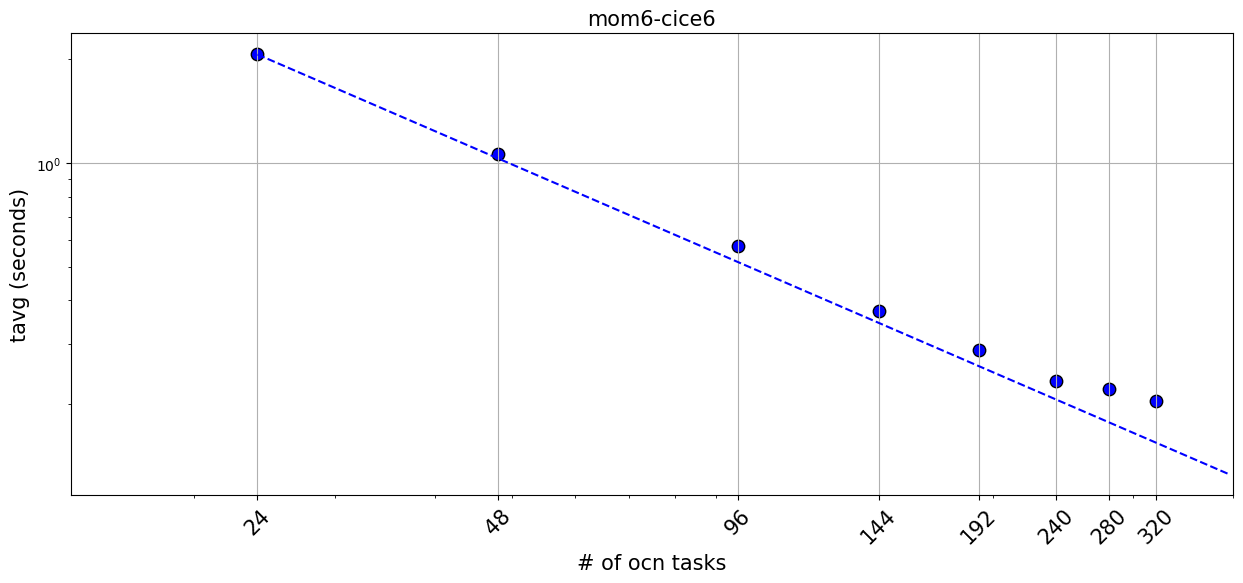

In [19]:
label_fontsize = 15
legend_fontsize = 12
nrows = 1
ncols = 1
figsize = (15, 6)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
axes = axes.flatten() if (nrows * ncols > 1) else [axes]

colors = ['r', 'b', 'g', 'darkorange', 'pink', 'cyan', 'lime', 'silver', 'gold', 'purple', 'grey', 'r', 'g', 'pink']

ocn_ntasks = [i['ocn_ntasks'] for i in task_values]
select_index = task_values_eff_indices
#regions_index = [0,1,2,11,5,6,7,8]
regions_index = [0,1]
update_regionNames = [regionNames[i] for i in regions_index]
regions_markers = ['P', 'o', 's', '^', 'v', 'D', 'p', '*']
regions_legend = [
    "ESMF (total)",
    "OCN",
    "ICE",
    "MED",
    "MED-TO-OCN",
    "OCN-TO-MED",
    "MED-TO-ICE",
    "ICE-TO-MED",
]
focus_regions_index = [1]
ideal_regions_index = [1]
plot_x_values_all = []
plot_y_values_all = []
key_x = 'ocn_ntasks'
x_range = [14, 400]
start_index = 0
incre=12
for i in select_index:
    plot_x_values = task_values[i][key_x]
    plot_x_values_all.append(plot_x_values)
    region_marker_pairs = zip(range(len(regions_index)), regions_markers)
    try:
        for region_indx, marker in region_marker_pairs:
            if region_indx in focus_regions_index:
                #print(runtime_tot[i][update_regionNames[region_indx]])
                axes[0].scatter(plot_x_values, runtime_tot[i][update_regionNames[region_indx]], marker=marker,
                            facecolors=colors[region_indx], edgecolors='k', s=80)
                plot_y_values_all.append(runtime_tot[i][update_regionNames[region_indx]])
            else:
                pass
            if region_indx in ideal_regions_index:
                if i == select_index[0]:
                    ix, iy = ideal_points_based_on_dataset(task_values,select_index,start_index,key_x,update_regionNames,region_indx,runtime_tot, x_range,incre=incre)
                    axes[0].plot(ix, iy, '--', color=colors[region_indx])
    except KeyError:
        pass

black_marker_legend = []
for i in range(len(regions_index)):
    black_marker_legend_tmp = plt.scatter([0], [0], marker=regions_markers[i], facecolors=f"{colors[i]}", edgecolors='k', s=80, label=f"{regions_legend[i]}")
    black_marker_legend.append(black_marker_legend_tmp)

# title = 'mom6-cice6'
# axes[0].legend(handles=black_marker_legend, loc='lower left', fontsize=legend_fontsize)


axes[0].grid(True)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
xticks = [ocn_ntasks[i] for i in task_values_eff_indices]
xticks_unique = list(dict.fromkeys(xticks))
axes[0].set_xticks(xticks_unique)
axes[0].set_xticklabels(xticks_unique, rotation=45, fontsize=label_fontsize)
# axes[0].xaxis.set_major_locator(LogLocator(base=10.0, numticks=10))  # Major ticks
# axes[0].xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))  # Minor ticks
# axes[0].yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))  # Major ticks for y-axis
# axes[0].yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))  # Minor ticks for y-axis
axes[0].set_xlabel('# of ocn tasks', fontsize=label_fontsize)
axes[0].set_ylabel('tavg (seconds)', fontsize=label_fontsize)
axes[0].set_title(title, fontsize=label_fontsize)
xlims = x_range
axes[0].set_xlim(xlims)
plt.show()

plot_x_values_str = ', '.join(map(str, plot_x_values_all))
plot_y_values_str = ', '.join(map(str, plot_y_values_all))
ix_str = ', '.join(map(str, ix))
iy_str = ', '.join(map(str, iy))

with open(os.path.join(tool_dir0, 'mom6-output'), 'w') as output:
    output.write(f'cores: {plot_x_values_str}\n')
    output.write(f'time: {plot_y_values_str}\n')
    output.write(f'ix: {ix_str}\n')
    output.write(f'iy: {iy_str}\n')

['/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_pre_ww3-3600/pt_3_test/archive/output000',
 '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_pre_ww3-3600/pt_1_test/archive/output000',
 '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_pre_ww3-3600/pt_7_test/archive/output000',
 '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_pre_ww3-3600/pt_6_test/archive/output000',
 '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_pre_ww3-3600/pt_13_test/archive/output000']
744.0
[12, 24, 32, 48, 72]
0
0.2220489247311828
1
0.11316048387096775
2
0.09174919354838709
3
0.07158051075268816
4
0.056491263440860216


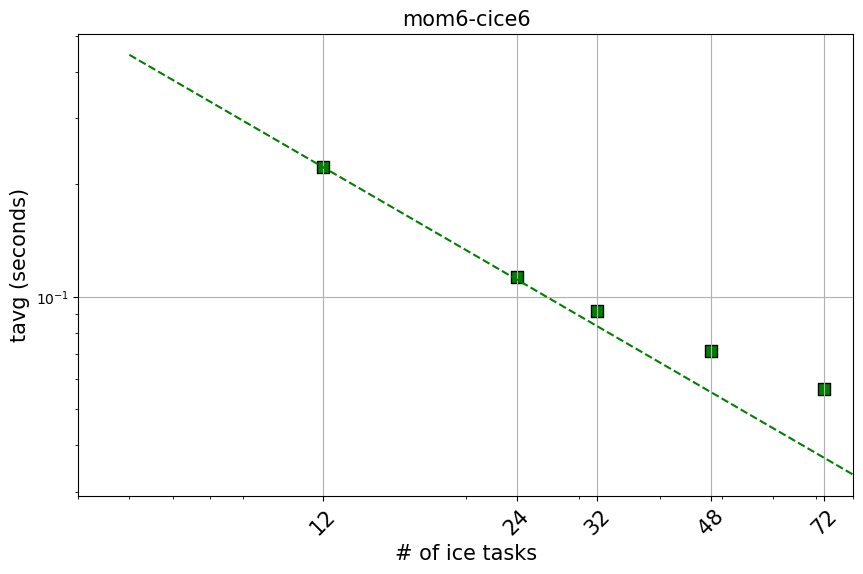

In [65]:
# CICE
MOM_full_paths = [
    '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_pre_ww3-3600/pt_3_test',
    '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_pre_ww3-3600/pt_1_test',
    '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_pre_ww3-3600/pt_7_test',
    '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_pre_ww3-3600/pt_6_test',
    '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_pre_ww3-3600/pt_13_test',
]
xxx = '000'
ESMF_paths = [f"{MOM_full_path}/archive/output{xxx}" for MOM_full_path in MOM_full_paths]
pprint(ESMF_paths)
file_read = [read_nuopc_config(os.path.join(ESMF_path, 'nuopc.runconfig')) for ESMF_path in ESMF_paths]
task_values = [f['PELAYOUT_attributes'] for f in file_read]
task_values_eff_indices = range(len(task_values))

regionNames = [
    '[ESMF]',
    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1',
    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ICE] RunPhase1',
    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ATM] RunPhase1',
    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ROF] RunPhase1',

    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1',
    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN-TO-MED] RunPhase1',
    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-ICE] RunPhase1',
    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ICE-TO-MED] RunPhase1',

    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ATM-TO-MED] RunPhase1',
    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ROF-TO-MED] RunPhase1',

    '[ESMF]/[ensemble] Init 1/[ESM0001] IPDv02p5/[MED] IPDv03p7/MED: (med_map_mod: RouteHandles_init)',
    '[ESMF]/[ensemble] Init 1/[ESM0001] IPDv02p3/[ATM] IPDv01p3',
    '[ESMF]/[ensemble] Init 1/[ESM0001] IPDv02p3/[ROF] IPDv01p3',
    '[ESMF]/[ensemble] Init 1/[ESM0001] IPDv02p3/[ICE] IPDv01p3',
]

dt=3600
num_baroclinic_ts = 31*24*3600/dt
print(num_baroclinic_ts)
profile_prefix='ESMF_Profile'
# ESMF_Profile.xxx    : (0. count, 1. total, 2. self_time, 3. mean    , 4. min_time, 5. max_time           )
# ESMF_Profile.summary: (0. count, 1. PETs , 2. mean     , 3. min_time, 4. max_time, 5. min_PET, 6. max_PET)
esmf_summary = True
index = 2
runtime_tot = collect_runtime_tot(ESMF_paths, regionNames=regionNames, profile_prefix=profile_prefix, esmf_summary=esmf_summary, index=index)
for tmp in runtime_tot:
    for k,v in tmp.items():
        tmp[k] = v/num_baroclinic_ts
label_fontsize = 15
legend_fontsize = 12
nrows = 1
ncols = 1
figsize = (10, 6)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
axes = axes.flatten() if (nrows * ncols > 1) else [axes]

colors = ['r', 'b', 'g', 'darkorange', 'pink', 'cyan', 'lime', 'silver', 'gold', 'purple', 'grey', 'r', 'g', 'pink']

ntasks = [i['ice_ntasks'] for i in task_values]
print(ntasks)
select_index = task_values_eff_indices
regions_index = [0,1,2,11,5,6,7,8]
update_regionNames = [regionNames[i] for i in regions_index]
regions_markers = ['P', 'o', 's', '^', 'v', 'D', 'p', '*']
regions_legend = [
    "ESMF (total)",
    "OCN",
    "ICE",
    "MED",
    "MED-TO-OCN",
    "OCN-TO-MED",
    "MED-TO-ICE",
    "ICE-TO-MED",
]
focus_regions_index = [2]
ideal_regions_index = [2]
plot_x_values_all = []
plot_y_values_all = []
key_x = 'ice_ntasks'
x_range = [5, 80]
start_index = 0
incre=2
for i in select_index:
    print(i)
    plot_x_values = task_values[i][key_x]
    plot_x_values_all.append(plot_x_values)
    region_marker_pairs = zip(range(len(regions_index)), regions_markers)
    try:
        for region_indx, marker in region_marker_pairs:
            if region_indx in focus_regions_index:
                print(runtime_tot[i][update_regionNames[region_indx]])
                axes[0].scatter(plot_x_values, runtime_tot[i][update_regionNames[region_indx]], marker=marker,
                            facecolors=colors[region_indx], edgecolors='k', s=80)
                plot_y_values_all.append(runtime_tot[i][update_regionNames[region_indx]])
            else:
                pass
            if region_indx in ideal_regions_index:
                if i == select_index[0]:
                    ix, iy = ideal_points_based_on_dataset(task_values,select_index,start_index,key_x,update_regionNames,region_indx,runtime_tot,x_range,incre=incre)
                    axes[0].plot(ix, iy, '--', color=colors[region_indx])
    except KeyError:
        pass

black_marker_legend = []
for i in range(len(regions_index)):
    black_marker_legend_tmp = plt.scatter([0], [0], marker=regions_markers[i], facecolors=f"{colors[i]}", edgecolors='k', s=80, label=f"{regions_legend[i]}")
    black_marker_legend.append(black_marker_legend_tmp)

# title = 'mom6-cice6'
# axes[0].legend(handles=black_marker_legend, loc='lower left', fontsize=legend_fontsize)


axes[0].grid(True)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
xticks = [ntasks[i] for i in task_values_eff_indices]
xticks_unique = list(dict.fromkeys(xticks))
axes[0].set_xticks(xticks_unique)
axes[0].set_xticklabels(xticks_unique, rotation=45, fontsize=label_fontsize)
# axes[0].xaxis.set_major_locator(LogLocator(base=10.0, numticks=10))  # Major ticks
# axes[0].xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))  # Minor ticks
# axes[0].yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))  # Major ticks for y-axis
# axes[0].yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))  # Minor ticks for y-axis
axes[0].set_xlabel('# of ice tasks', fontsize=label_fontsize)
axes[0].set_ylabel('tavg (seconds)', fontsize=label_fontsize)
axes[0].set_title(title, fontsize=label_fontsize)
xlims = x_range
axes[0].set_xlim(xlims)
plt.show()

plot_x_values_str = ', '.join(map(str, plot_x_values_all))
plot_y_values_str = ', '.join(map(str, plot_y_values_all))
ix_str = ', '.join(map(str, ix))
iy_str = ', '.join(map(str, iy))

with open(os.path.join(tool_dir0, 'cice6-output'), 'w') as output:
    output.write(f'cores: {plot_x_values_str}\n')
    output.write(f'time: {plot_y_values_str}\n')
    output.write(f'ix: {ix_str}\n')
    output.write(f'iy: {iy_str}\n')

In [78]:
MOM_full_paths = []
for f in os.listdir(os.path.join(expts_manager_path, test_rel_path)):
    if f.startswith('pt'):
        MOM_full_path = os.path.join(expts_manager_path, test_rel_path, f)
        MOM_full_paths.append(MOM_full_path)
MOM_full_paths.sort()
MOM_full_paths = [
    '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_ww3_cpl_3600_fsd_off/pt_2_test',
    '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_ww3_cpl_3600_fsd_off/pt_3_test',
    '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_ww3_cpl_3600_fsd_off/pt_4_test',
    '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_ww3_cpl_3600_fsd_off/pt_5_test',
    '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_ww3_cpl_3600_fsd_off/pt_6_test',
    '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_ww3_cpl_3600_fsd_off/pt_7_test-wav-concurrent-ocn-96-all',
    '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_ww3_cpl_3600_fsd_off/pt_8_test',
    '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_ww3_cpl_3600_fsd_off/pt_7_test-wav-concurrent-384-ocn-96-all',
    '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_ww3_cpl_3600_fsd_off/pt_7_test-wav-concurrent-408-ocn-96-all',
]
xxx = '000'
ESMF_paths = [f"{MOM_full_path}/archive/output{xxx}" for MOM_full_path in MOM_full_paths]
pprint(ESMF_paths)
file_read = [read_nuopc_config(os.path.join(ESMF_path, 'nuopc.runconfig')) for ESMF_path in ESMF_paths]
task_values = [f['PELAYOUT_attributes'] for f in file_read]
task_values_eff_indices = range(len(task_values))

regionNames = [
    '[ESMF]',
    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN] RunPhase1',
    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ICE] RunPhase1',
    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ATM] RunPhase1',
    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ROF] RunPhase1',
    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[WAV] RunPhase1',

    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-OCN] RunPhase1',
    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[OCN-TO-MED] RunPhase1',
    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[MED-TO-ICE] RunPhase1',
    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ICE-TO-MED] RunPhase1',

    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ATM-TO-MED] RunPhase1',
    '[ESMF]/[ensemble] RunPhase1/[ESM0001] RunPhase1/[ROF-TO-MED] RunPhase1',

    '[ESMF]/[ensemble] Init 1/[ESM0001] IPDv02p5/[MED] IPDv03p7/MED: (med_map_mod: RouteHandles_init)',
    '[ESMF]/[ensemble] Init 1/[ESM0001] IPDv02p3/[ATM] IPDv01p3',
    '[ESMF]/[ensemble] Init 1/[ESM0001] IPDv02p3/[ROF] IPDv01p3',
    '[ESMF]/[ensemble] Init 1/[ESM0001] IPDv02p3/[ICE] IPDv01p3',
]

dt=3600
num_baroclinic_ts = 31*24*3600/dt
print(num_baroclinic_ts)
profile_prefix='ESMF_Profile'
# ESMF_Profile.xxx    : (0. count, 1. total, 2. self_time, 3. mean    , 4. min_time, 5. max_time           )
# ESMF_Profile.summary: (0. count, 1. PETs , 2. mean     , 3. min_time, 4. max_time, 5. min_PET, 6. max_PET)
esmf_summary = True
index = 2
runtime_tot = collect_runtime_tot(ESMF_paths, regionNames=regionNames, profile_prefix=profile_prefix, esmf_summary=esmf_summary, index=index)
for tmp in runtime_tot:
    for k,v in tmp.items():
        tmp[k] = v/num_baroclinic_ts

['/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_ww3_cpl_3600_fsd_off/pt_2_test/archive/output000',
 '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_ww3_cpl_3600_fsd_off/pt_3_test/archive/output000',
 '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_ww3_cpl_3600_fsd_off/pt_4_test/archive/output000',
 '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_ww3_cpl_3600_fsd_off/pt_5_test/archive/output000',
 '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_ww3_cpl_3600_fsd_off/pt_6_test/archive/output000',
 '/g/data/tm70/ml0072/COMMON/git_repos/COSIMA_om3-scripts/expts_manager/product1_1deg_scaling_performance_real_ww3_cpl_3600_fsd_off/pt_7_test-wav-concurrent-ocn-96-all/archive/output000',
 '

[48, 96, 144, 192, 240, 288, 336, 384, 408]
0
3.049341935483871
1
1.9772778225806453
2
1.5489225806451614
3
1.2247379032258066
4
1.0725362903225806
5
0.9030751344086021
6
0.9218467741935484
7
0.716554569892473
8
0.6919830645161291


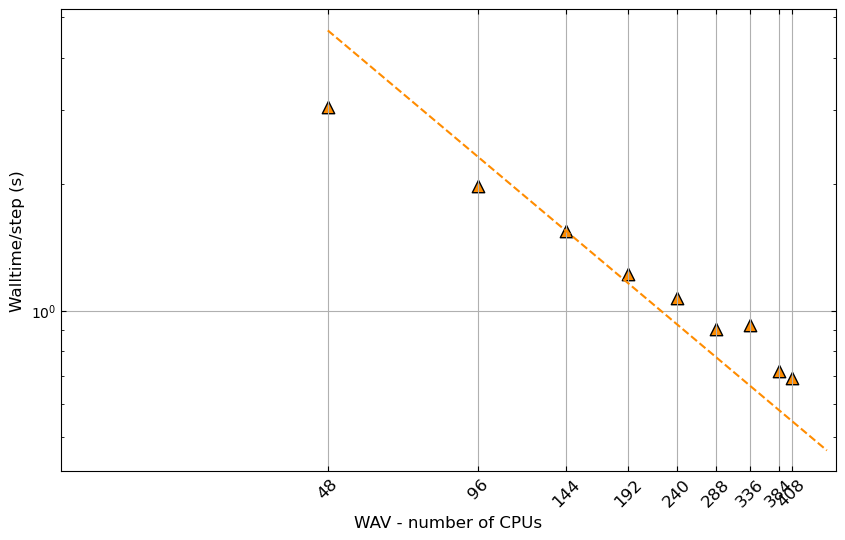

In [79]:
label_fontsize = 12
legend_fontsize = 12
nrows = 1
ncols = 1
figsize = (10, 6)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
axes = axes.flatten() if (nrows * ncols > 1) else [axes]

colors = ['r', 'b', 'g', 'darkorange', 'pink', 'cyan', 'lime', 'silver', 'gold', 'purple', 'grey', 'r', 'g', 'pink']

ocn_ntasks = [i['wav_ntasks'] for i in task_values]
print(ocn_ntasks)
select_index = task_values_eff_indices
regions_index = [0,1,2,5,11,6,7,8,9]
update_regionNames = [regionNames[i] for i in regions_index]
regions_markers = ['P', 'o', 's', '^', 'v', 'D', 'p', '*','>','<']
regions_legend = [
    "ESMF (total)",
    "OCN",
    "ICE",
    "WAV",
    "MED",
    "MED-TO-OCN",
    "OCN-TO-MED",
    "MED-TO-ICE",
    "ICE-TO-MED",
]
focus_regions_index = [3]
ideal_regions_index = [3]
plot_x_values_all = []
plot_y_values_all = []
key_x = 'wav_ntasks'
x_range = [14, 500]
start_index = 2
incre=48
for i in select_index:
    print(i)
    plot_x_values = task_values[i][key_x]
    plot_x_values_all.append(plot_x_values)
    region_marker_pairs = zip(range(len(regions_index)), regions_markers)
    try:
        for region_indx, marker in region_marker_pairs:
            if region_indx in focus_regions_index:
                print(runtime_tot[i][update_regionNames[region_indx]])
                axes[0].scatter(plot_x_values, runtime_tot[i][update_regionNames[region_indx]], marker=marker,
                            facecolors=colors[region_indx], edgecolors='k', s=80)
                plot_y_values_all.append(runtime_tot[i][update_regionNames[region_indx]])
            else:
                pass
            if region_indx in ideal_regions_index:
                if i == select_index[0]:
                    ix, iy = ideal_points_based_on_dataset(task_values,select_index,start_index,key_x,update_regionNames,region_indx,runtime_tot,x_range,incre=incre)
                    axes[0].plot(ix, iy, '--', color=colors[region_indx])
    except KeyError:
        pass

black_marker_legend = []
for i in range(len(regions_index)):
    black_marker_legend_tmp = plt.scatter([0], [0], marker=regions_markers[i], facecolors=f"{colors[i]}", edgecolors='k', s=80, label=f"{regions_legend[i]}")
    black_marker_legend.append(black_marker_legend_tmp)

# title = 'mom6-cice6'
# axes[0].legend(handles=black_marker_legend, loc='lower left', fontsize=legend_fontsize)


axes[0].grid(True)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
xticks = [ocn_ntasks[i] for i in task_values_eff_indices]
xticks_unique = list(dict.fromkeys(xticks))
axes[0].set_xticks(xticks_unique)
axes[0].set_xticklabels(xticks_unique, rotation=45, fontsize=label_fontsize)
axes[0].xaxis.set_minor_locator(plt.NullLocator())
plt.gca().tick_params(axis='both', which='both', direction='in', top=True, right=True)
# axes[0].xaxis.set_major_locator(LogLocator(base=10.0, numticks=10))  # Major ticks
# axes[0].xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))  # Minor ticks
# axes[0].yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))  # Major ticks for y-axis
# axes[0].yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))  # Minor ticks for y-axis
axes[0].set_xlabel('WAV - number of CPUs', fontsize=label_fontsize)
axes[0].set_ylabel('Walltime/step (s)', fontsize=label_fontsize)
#axes[0].set_title(title, fontsize=label_fontsize)
xlims = x_range

axes[0].set_xlim(xlims)
plt.show()

plot_x_values_str = ', '.join(map(str, plot_x_values_all))
plot_y_values_str = ', '.join(map(str, plot_y_values_all))
ix_str = ', '.join(map(str, ix))
iy_str = ', '.join(map(str, iy))

with open(os.path.join(tool_dir0, 'ww3-output'), 'w') as output:
    output.write(f'cores: {plot_x_values_str}\n')
    output.write(f'time: {plot_y_values_str}\n')
    output.write(f'ix: {ix_str}\n')
    output.write(f'iy: {iy_str}\n')

[48, 96, 144, 192, 240, 288, 336, 384, 408]
0
3.2293834677419357
1
2.1147638440860215
2
1.6721985215053765
3
1.3417094086021506
4
1.1861977150537635
5
0.9652081989247312
6
1.0286516129032257
7
0.7802641129032257
8
0.7546049731182796


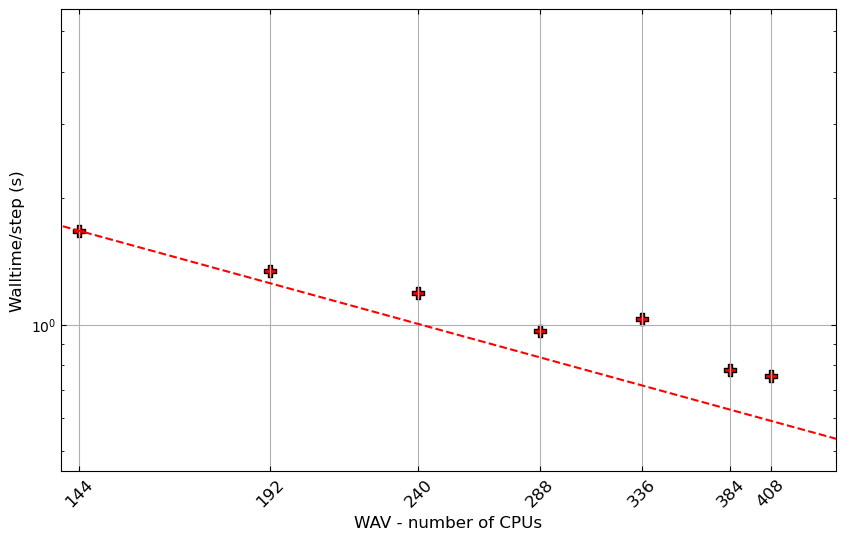

In [80]:
label_fontsize = 12
legend_fontsize = 12
nrows = 1
ncols = 1
figsize = (10, 6)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
axes = axes.flatten() if (nrows * ncols > 1) else [axes]

colors = ['r', 'b', 'g', 'darkorange', 'pink', 'cyan', 'lime', 'silver', 'gold', 'purple', 'grey', 'r', 'g', 'pink']

ocn_ntasks = [i['wav_ntasks'] for i in task_values]
print(ocn_ntasks)
select_index = task_values_eff_indices
regions_index = [0,1,2,5,11,6,7,8,9]
update_regionNames = [regionNames[i] for i in regions_index]
regions_markers = ['P', 'o', 's', '^', 'v', 'D', 'p', '*','>','<']
regions_legend = [
    "ESMF (total)",
    "OCN",
    "ICE",
    "WAV",
    "MED",
    "MED-TO-OCN",
    "OCN-TO-MED",
    "MED-TO-ICE",
    "ICE-TO-MED",
]
focus_regions_index = [0]
ideal_regions_index = [0]
plot_x_values_all = []
plot_y_values_all = []
key_x = 'wav_ntasks'
x_range = [14, 500]
start_index = 2
incre=48
for i in select_index:
    print(i)
    plot_x_values = task_values[i][key_x]
    plot_x_values_all.append(plot_x_values)
    region_marker_pairs = zip(range(len(regions_index)), regions_markers)
    try:
        for region_indx, marker in region_marker_pairs:
            if region_indx in focus_regions_index:
                print(runtime_tot[i][update_regionNames[region_indx]])
                axes[0].scatter(plot_x_values, runtime_tot[i][update_regionNames[region_indx]], marker=marker,
                            facecolors=colors[region_indx], edgecolors='k', s=80)
                plot_y_values_all.append(runtime_tot[i][update_regionNames[region_indx]])
            else:
                pass
            if region_indx in ideal_regions_index:
                if i == select_index[0]:
                    ix, iy = ideal_points_based_on_dataset(task_values,select_index,start_index,key_x,update_regionNames,region_indx,runtime_tot,x_range,incre=incre)
                    axes[0].plot(ix, iy, '--', color=colors[region_indx])
    except KeyError:
        pass

black_marker_legend = []
for i in range(len(regions_index)):
    black_marker_legend_tmp = plt.scatter([0], [0], marker=regions_markers[i], facecolors=f"{colors[i]}", edgecolors='k', s=80, label=f"{regions_legend[i]}")
    black_marker_legend.append(black_marker_legend_tmp)

# title = 'mom6-cice6'
# axes[0].legend(handles=black_marker_legend, loc='lower left', fontsize=legend_fontsize)


axes[0].grid(True)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
xticks = [ocn_ntasks[i] for i in task_values_eff_indices]
xticks_unique = list(dict.fromkeys(xticks))
axes[0].set_xticks(xticks_unique)
axes[0].set_xticklabels(xticks_unique, rotation=45, fontsize=label_fontsize)
axes[0].xaxis.set_minor_locator(plt.NullLocator())
plt.gca().tick_params(axis='both', which='both', direction='in', top=True, right=True)
# axes[0].xaxis.set_major_locator(LogLocator(base=10.0, numticks=10))  # Major ticks
# axes[0].xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))  # Minor ticks
# axes[0].yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))  # Major ticks for y-axis
# axes[0].yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))  # Minor ticks for y-axis
axes[0].set_xlabel('WAV - number of CPUs', fontsize=label_fontsize)
axes[0].set_ylabel('Walltime/step (s)', fontsize=label_fontsize)
#axes[0].set_title(title, fontsize=label_fontsize)
xlims = x_range

axes[0].set_xlim(xlims)
axes[0].set_xlim([140,450])
plt.show()

plot_x_values_str = ', '.join(map(str, plot_x_values_all))
plot_y_values_str = ', '.join(map(str, plot_y_values_all))
ix_str = ', '.join(map(str, ix))
iy_str = ', '.join(map(str, iy))

with open(os.path.join(tool_dir0, 'ww3-output-all'), 'w') as output:
    output.write(f'cores: {plot_x_values_str}\n')
    output.write(f'time: {plot_y_values_str}\n')
    output.write(f'ix: {ix_str}\n')
    output.write(f'iy: {iy_str}\n')

[48, 96, 144, 192, 240, 288, 336, 384, 408]
0
3.049341935483871
1
1.9772778225806453
2
1.5489225806451614
3
1.2247379032258066
4
1.0725362903225806
5
0.9030751344086021
6
0.9218467741935484
7
0.716554569892473
8
0.6919830645161291


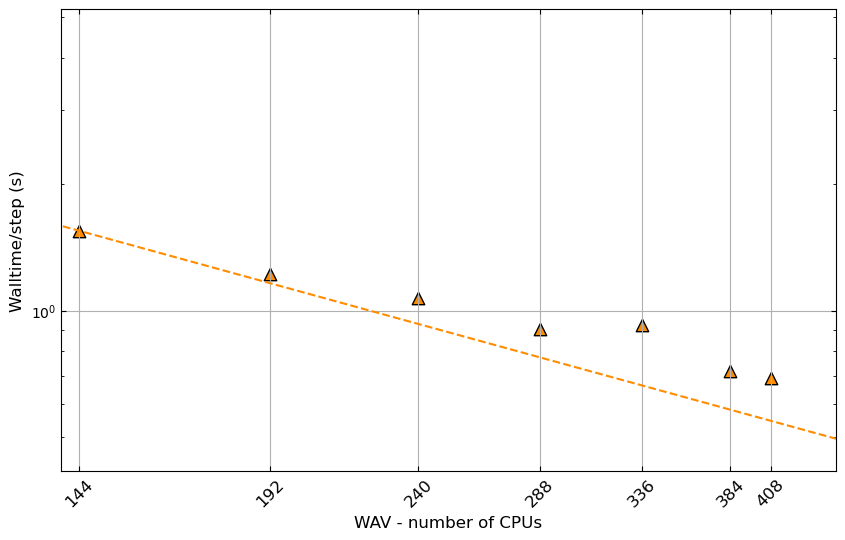

In [81]:
label_fontsize = 12
legend_fontsize = 12
nrows = 1
ncols = 1
figsize = (10, 6)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
axes = axes.flatten() if (nrows * ncols > 1) else [axes]

colors = ['r', 'b', 'g', 'darkorange', 'pink', 'cyan', 'lime', 'silver', 'gold', 'purple', 'grey', 'r', 'g', 'pink']

ocn_ntasks = [i['wav_ntasks'] for i in task_values]
print(ocn_ntasks)
select_index = task_values_eff_indices
regions_index = [0,1,2,5,11,6,7,8,9]
update_regionNames = [regionNames[i] for i in regions_index]
regions_markers = ['P', 'o', 's', '^', 'v', 'D', 'p', '*','>','<']
regions_legend = [
    "ESMF (total)",
    "OCN",
    "ICE",
    "WAV",
    "MED",
    "MED-TO-OCN",
    "OCN-TO-MED",
    "MED-TO-ICE",
    "ICE-TO-MED",
]
focus_regions_index = [3]
ideal_regions_index = [3]
plot_x_values_all = []
plot_y_values_all = []
key_x = 'wav_ntasks'
x_range = [14, 500]
start_index = 2
incre=48
for i in select_index:
    print(i)
    plot_x_values = task_values[i][key_x]
    plot_x_values_all.append(plot_x_values)
    region_marker_pairs = zip(range(len(regions_index)), regions_markers)
    try:
        for region_indx, marker in region_marker_pairs:
            if region_indx in focus_regions_index:
                print(runtime_tot[i][update_regionNames[region_indx]])
                axes[0].scatter(plot_x_values, runtime_tot[i][update_regionNames[region_indx]], marker=marker,
                            facecolors=colors[region_indx], edgecolors='k', s=80)
                plot_y_values_all.append(runtime_tot[i][update_regionNames[region_indx]])
            else:
                pass
            if region_indx in ideal_regions_index:
                if i == select_index[0]:
                    ix, iy = ideal_points_based_on_dataset(task_values,select_index,start_index,key_x,update_regionNames,region_indx,runtime_tot,x_range,incre=incre)
                    axes[0].plot(ix, iy, '--', color=colors[region_indx])
    except KeyError:
        pass

black_marker_legend = []
for i in range(len(regions_index)):
    black_marker_legend_tmp = plt.scatter([0], [0], marker=regions_markers[i], facecolors=f"{colors[i]}", edgecolors='k', s=80, label=f"{regions_legend[i]}")
    black_marker_legend.append(black_marker_legend_tmp)

# title = 'mom6-cice6'
# axes[0].legend(handles=black_marker_legend, loc='lower left', fontsize=legend_fontsize)


axes[0].grid(True)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
xticks = [ocn_ntasks[i] for i in task_values_eff_indices]
xticks_unique = list(dict.fromkeys(xticks))
axes[0].set_xticks(xticks_unique)
axes[0].set_xticklabels(xticks_unique, rotation=45, fontsize=label_fontsize)
axes[0].xaxis.set_minor_locator(plt.NullLocator())
plt.gca().tick_params(axis='both', which='both', direction='in', top=True, right=True)
# axes[0].xaxis.set_major_locator(LogLocator(base=10.0, numticks=10))  # Major ticks
# axes[0].xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))  # Minor ticks
# axes[0].yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))  # Major ticks for y-axis
# axes[0].yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))  # Minor ticks for y-axis
axes[0].set_xlabel('WAV - number of CPUs', fontsize=label_fontsize)
axes[0].set_ylabel('Walltime/step (s)', fontsize=label_fontsize)
#axes[0].set_title(title, fontsize=label_fontsize)
xlims = x_range

axes[0].set_xlim(xlims)
axes[0].set_xlim([140,450])
plt.show()

plot_x_values_str = ', '.join(map(str, plot_x_values_all))
plot_y_values_str = ', '.join(map(str, plot_y_values_all))
ix_str = ', '.join(map(str, ix))
iy_str = ', '.join(map(str, iy))

with open(os.path.join(tool_dir0, 'ww3-output'), 'w') as output:
    output.write(f'cores: {plot_x_values_str}\n')
    output.write(f'time: {plot_y_values_str}\n')
    output.write(f'ix: {ix_str}\n')
    output.write(f'iy: {iy_str}\n')

In [60]:
def read_cores_data(tool_dir0, filename):
    # Specify the path to the output file
    output_file_path = os.path.join(tool_dir0, filename)
    
    # Read from the output file
    with open(output_file_path, 'r') as input_file:
        # Read all lines into a list
        lines = input_file.readlines()
    
    # Process the data
    plot_x_values = []
    plot_y_values = []
    ix = iy = None  # Initialize indices
    
    for line in lines:
        if line.startswith("cores:"):
            # Extract and convert X values
            plot_x_values = list(map(float, line.split(':')[1].strip().split(', ')))
        elif line.startswith("time:"):
            # Extract and convert Y values
            plot_y_values = list(map(float, line.split(':')[1].strip().split(', ')))
        elif line.startswith("ix:"):
            # Extract X index
            ix = list(map(float, line.split(':')[1].strip().split(', ')))
        elif line.startswith("iy:"):
            # Extract Y index
            iy = list(map(float, line.split(':')[1].strip().split(', ')))

    return plot_x_values, plot_y_values, ix, iy

In [108]:
plot_x_valuesm, plot_y_valuesm, ixm, iym = read_cores_data(tool_dir0, 'mom6-output')
plot_x_valuesi, plot_y_valuesi, ixi, iyi = read_cores_data(tool_dir0, 'cice6-output')
plot_x_valuesw, plot_y_valuesw, ixw, iyw = read_cores_data(tool_dir0, 'ww3-output')
plot_x_valuesa, plot_y_valuesa, ixa, iya = read_cores_data(tool_dir0, 'ww3-output-all')
print(plot_x_valuesw)
print(plot_y_valuesw)


[48.0, 96.0, 144.0, 192.0, 240.0, 288.0, 336.0, 384.0, 408.0]
[3.049341935483871, 1.9772778225806453, 1.5489225806451614, 1.2247379032258066, 1.0725362903225806, 0.9030751344086021, 0.9218467741935484, 0.716554569892473, 0.6919830645161291]


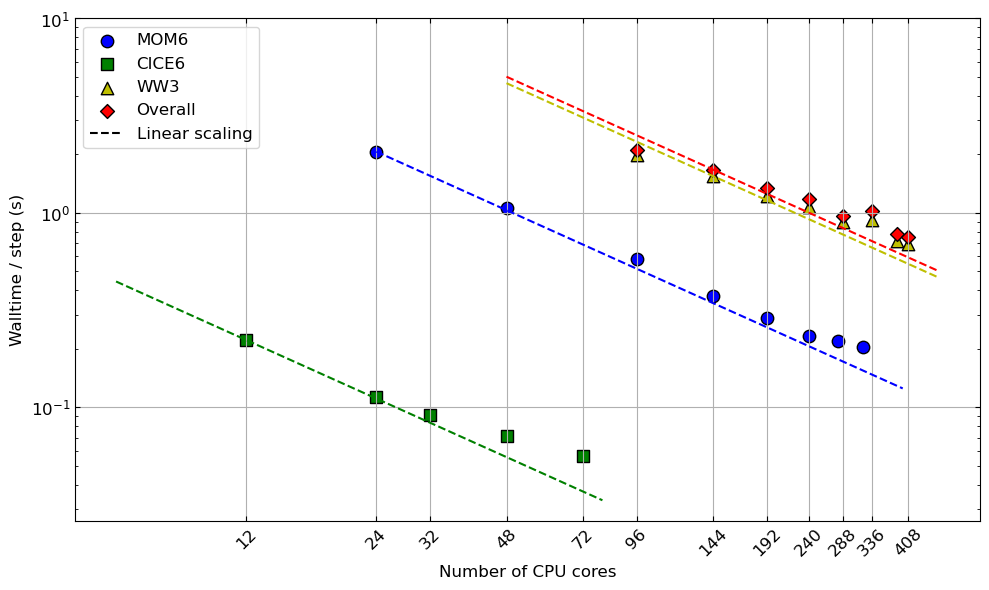

In [117]:
label_fontsize = 12
legend_fontsize = 12
marker = ['P', 'o', 's', '^', 'v', 'D', 'p', '*']
nrows = 1
ncols = 1
figsize = (10, 6)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
axes = axes.flatten() if (nrows * ncols > 1) else [axes]

colors = ['r', 'b', 'g', 'darkorange', 'pink', 'cyan', 'lime', 'silver', 'gold', 'purple', 'grey', 'r', 'g', 'pink']
axes[0].scatter(plot_x_valuesm, plot_y_valuesm, marker='o',
                            facecolors='b', edgecolors='k', s=80)

axes[0].scatter(plot_x_valuesi, plot_y_valuesi, marker='s',
                            facecolors='g', edgecolors='k', s=80)

axes[0].scatter(plot_x_valuesw[1:], plot_y_valuesw[1:], marker='^',
                            facecolors='y', edgecolors='k', s=80)

axes[0].scatter(plot_x_valuesa[1:], plot_y_valuesa[1:], marker='D',
                            facecolors='r', edgecolors='k', s=50)
axes[0].plot([], [], '--', color='k')
axes[0].plot(ixm, iym, '--', color='b')
axes[0].plot(ixi, iyi, '--', color='g')
axes[0].plot(ixw, iyw, '--', color='y')
axes[0].plot(ixa, iya, '--', color='r')

axes[0].grid(True)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].legend(['MOM6','CICE6','WW3','Overall', 'Linear scaling'], loc='upper left', fontsize=legend_fontsize)
xticks = [12, 24, 32, 48, 72, 96, 144, 192, 240, 288, 336, 408]
xticks_unique = list(dict.fromkeys(xticks))
axes[0].set_xticks(xticks_unique)
axes[0].set_xticklabels(xticks_unique, rotation=45, fontsize=label_fontsize)
axes[0].set_yticks([0.1, 1.0, 10])
axes[0].set_yticklabels(['$10^{-1}$', '$10^0$', '$10^1$'], rotation=0, fontsize=label_fontsize)
axes[0].xaxis.set_minor_locator(plt.NullLocator())
plt.gca().tick_params(axis='both', which='both', direction='in', top=True, right=True)
axes[0].set_xlabel('Number of CPU cores', fontsize=label_fontsize)
axes[0].set_ylabel('Walltime / step (s)', fontsize=label_fontsize)
plt.tight_layout()
pic_name = "performance_plot"
file_path = os.path.join(tool_dir0, pic_name+ ".png")
plt.savefig(file_path,dpi=400)
plt.show()